# Experimentación - LSTM 



## 1. Obtención de datos



In [10]:

import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv
import itertools
import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid


from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from utils.utils_graph import format_plot, plot_training_and_eval_losses, plot_predictions



from utils.models import LSTMModel
from utils.trainer import  TrainerLSTMModel
import utils.utils_graph

dtype = torch.float
device = torch.device("cpu")

In [11]:
from importlib import reload
utils.utils_graph = reload(utils.utils_graph)
from utils.utils_graph import *

In [12]:
from importlib import reload
import utils.trainer
utils.trainer = reload(utils.trainer)
from utils.trainer import TrainerLSTMModel

In [13]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [14]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="classification_type")
_,_,_ =loader.process()
limit = 300
dataset_full, situations_each = loader.get_dataset()
target_names = loader.target_names

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

## Prueba - predicción por tipos - usando batch 

Algunos modelos de los que veremos luego admiten entrenamiento por batch, y otros no, por lo que guardaremos los resultados de LSTM en ambos casos, para poder compararlos.

En GNNs el entrenamiento por batch muchas veces carece de sentido, porque estaríamos modelando todos los grafos del mismo batch como el mismo grafo, perdiendo información que puede ser valiosa.

In [15]:
def entrenar_y_evaluar_modelos(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem="Classification", name=None,target_names=None):

    resultados_list = []

    # Guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    n_nodes = dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[0]
    n_features = dataset[0].x.shape[1]

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for hidden_size, n_layers in tqdm(list(itertools.product(param_grid["hidden_size"], param_grid["n_layers"]))):
        model = LSTMModel(name=name, node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=hidden_size, num_layers=n_layers, is_classification=True)
        trainer = TrainerLSTMModel(model, dataset, device, f"../experimentos_split/results/{problem}", dataloader_params, batch=True, is_classification=True)

        # Training the model
        losses, eval_losses, accs, precisions, recalls, f1s = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = trainer.test()


        results_intermedio = {
            "Hidden Size": hidden_size,
            "Layers": n_layers,
            "Loss_final": losses[-1],  
            "Accuracy_eval": np.mean(accs),
            "Precision_eval": np.mean(precisions),
            "Recall_eval": np.mean(recalls),
            "F1_eval": np.mean(f1s),
            "Loss_eval": np.mean(eval_losses[-1]), 
            "Loss_tst": np.mean(test_loss),
            "Accuracy_tst": test_acc,
            "Precision_tst": test_precision,
            "Recall_tst": test_recall,
            "F1_tst": test_f1
        }
        
        resultados_list.append(results_intermedio)

        # Actualizando el mejor modelo si es necesario
        if np.mean(test_loss) < mejor_loss_test:
            mejor_loss_test = np.mean(test_loss)
            mejor_trainer = trainer
            mejores_parametros = {'Hidden Size': hidden_size, 'Layers': n_layers}
            mejores_resultados = results_intermedio

        print("Parámetros: ", hidden_size, n_layers)
        print("Resultados: ", resultados_list[-1])

    resultados_df = pd.DataFrame(resultados_list)
    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_df

## Bucle rápido para ajustar y guardar resultados con batch

In [16]:


param_grid = {
    "hidden_size": [50, 100, 150],  
    "n_layers": [1, 2, 3]          
}

dataloader_params = {
    "batch_size": 32,
    "data_split_ratio": [0.7, 0.15, 0.15],
    "seed": 42,
    "keep_same": True,
    "use_batch": True
}

num_early_stop = 10
num_epochs = 100
problem = "clasificacion"

mejor_trainer, mejores_parametros, mejores_resultados, resultados_df = entrenar_y_evaluar_modelos(
    param_grid, 
    dataset_full, 
    dataloader_params, 
    num_early_stop, 
    num_epochs, 
    problem, "LSTM_BATCH",target_names)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 390
Validation dataset: 75
Test dataset: 84

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 12
DataLoader for val set:
Number of batches: 2
DataLoader for test set:
Number of batches: 2

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 1.5481 | Eval Loss: 1.4493 | Accuracy: 0.5625 | Precision: 0.4332 | Recall: 0.3708 | F1-Score: 0.3251 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 1.5034 | Eval Loss: 1.4198 | Accuracy: 0.5469 | Precision: 0.2063 | Recall: 0.3600 | F1-Score: 0.2622 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 1.4708 | Eval Loss: 1.3893 | Accuracy: 0.5625 | Precision: 0.2147 | Recall: 0.3800 | F1-Score: 0.2741 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 1.4463 | Eval Loss: 1.3692 | Accuracy: 0.5625 | Precision: 0.2113 | Recall: 0.3800 | F1-Score: 0.2704 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 1.4328 | Eval Loss: 1.3582 | Ac

 11%|█         | 1/9 [00:12<01:39, 12.46s/it]

Epoch 52/100 | Train Loss: 1.0815 | Eval Loss: 1.1924 | Accuracy: 0.7031 | Precision: 0.6574 | Recall: 0.6973 | F1-Score: 0.6677 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.75      0.25      0.38        12
           1       0.55      0.67      0.60         9
           2       0.25      0.50      0.33         6
           3       1.00      1.00      1.00        16
           4       0.81      0.81      0.81        21

    accuracy                           0.70        64
   macro avg       0.67      0.65      0.62        64
weighted avg       0.76      0.70      0.70        64

preds:  ()
test loss: 1.181234, test accuracy: 0.7031, test precision: 0.6710, test recall: 0.6452, test F1-score: 0.6236
Parámetros:  50 1
Resultados:  {'Hidden Size': 50, 'Layers': 1, 'Loss_final': 1.0814732313156128, 'Accuracy_eval': 0.6589543269230769, 'Precision_eval': 0.5324941224103388, 'Recall_eval': 0.6

 22%|██▏       | 2/9 [00:26<01:34, 13.53s/it]

Epoch 52/100 | Train Loss: 1.2068 | Eval Loss: 1.2152 | Accuracy: 0.7188 | Precision: 0.7793 | Recall: 0.6419 | F1-Score: 0.6305 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.00      0.00      0.00         9
           2       0.38      0.50      0.43         6
           3       1.00      1.00      1.00        16
           4       0.70      1.00      0.82        21

    accuracy                           0.73        64
   macro avg       0.56      0.62      0.58        64
weighted avg       0.65      0.73      0.68        64

preds:  ()
test loss: 1.170212, test accuracy: 0.7344, test precision: 0.5550, test recall: 0.6167, test F1-score: 0.5777
Parámetros:  50 2
Resultados:  {'Hidden Size': 50, 'Layers': 2, 'Loss_final': 1.206792950630188, 'Accuracy_eval': 0.6421274038461539, 'Precision_eval': 0.5040827313421766, 'Recall_eval': 0.58

 33%|███▎      | 3/9 [00:41<01:23, 13.98s/it]

Epoch 52/100 | Train Loss: 1.2486 | Eval Loss: 1.2214 | Accuracy: 0.6875 | Precision: 0.5793 | Recall: 0.6108 | F1-Score: 0.5473 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.00      0.00      0.00         9
           2       0.33      0.17      0.22         6
           3       1.00      1.00      1.00        16
           4       0.66      1.00      0.79        21

    accuracy                           0.75        64
   macro avg       0.55      0.60      0.56        64
weighted avg       0.64      0.75      0.68        64

preds:  ()
test loss: 1.168152, test accuracy: 0.7500, test precision: 0.5518, test recall: 0.6000, test F1-score: 0.5629
Parámetros:  50 3
Resultados:  {'Hidden Size': 50, 'Layers': 3, 'Loss_final': 1.248591661453247, 'Accuracy_eval': 0.6310096153846154, 'Precision_eval': 0.39205209207435676, 'Recall_eval': 0.5

 44%|████▍     | 4/9 [00:53<01:06, 13.33s/it]

Epoch 52/100 | Train Loss: 1.0755 | Eval Loss: 1.1842 | Accuracy: 0.7188 | Precision: 0.6982 | Recall: 0.7361 | F1-Score: 0.6669 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.46      0.67      0.55         9
           2       0.17      0.17      0.17         6
           3       1.00      1.00      1.00        16
           4       0.84      0.76      0.80        21

    accuracy                           0.72        64
   macro avg       0.63      0.64      0.63        64
weighted avg       0.74      0.72      0.72        64

preds:  ()
test loss: 1.185127, test accuracy: 0.7188, test precision: 0.6341, test recall: 0.6357, test F1-score: 0.6297
Parámetros:  100 1
Resultados:  {'Hidden Size': 100, 'Layers': 1, 'Loss_final': 1.0754635334014893, 'Accuracy_eval': 0.6742788461538461, 'Precision_eval': 0.5724331267410332, 'Recall_eval': 0

 56%|█████▌    | 5/9 [01:08<00:55, 13.95s/it]

Epoch 52/100 | Train Loss: 1.3217 | Eval Loss: 1.3235 | Accuracy: 0.6875 | Precision: 0.5718 | Recall: 0.6526 | F1-Score: 0.5995 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       0.50      0.44      0.47         9
           2       0.00      0.00      0.00         6
           3       1.00      1.00      1.00        16
           4       0.79      0.90      0.84        21

    accuracy                           0.80        64
   macro avg       0.61      0.67      0.63        64
weighted avg       0.72      0.80      0.75        64

preds:  ()
test loss: 1.211567, test accuracy: 0.7969, test precision: 0.6083, test recall: 0.6698, test F1-score: 0.6344
Parámetros:  100 2
Resultados:  {'Hidden Size': 100, 'Layers': 2, 'Loss_final': 1.3216655254364014, 'Accuracy_eval': 0.6262019230769231, 'Precision_eval': 0.5037570685934056, 'Recall_eval': 0

 67%|██████▋   | 6/9 [01:24<00:43, 14.56s/it]

Epoch 52/100 | Train Loss: 1.2624 | Eval Loss: 1.2237 | Accuracy: 0.6875 | Precision: 0.5793 | Recall: 0.6108 | F1-Score: 0.5473 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         6
           3       1.00      1.00      1.00        16
           4       0.64      1.00      0.78        21

    accuracy                           0.73        64
   macro avg       0.47      0.57      0.51        64
weighted avg       0.59      0.73      0.65        64

preds:  ()
test loss: 1.177927, test accuracy: 0.7344, test precision: 0.4701, test recall: 0.5667, test F1-score: 0.5094
Parámetros:  100 3
Resultados:  {'Hidden Size': 100, 'Layers': 3, 'Loss_final': 1.262442946434021, 'Accuracy_eval': 0.6433293269230769, 'Precision_eval': 0.4142062250869566, 'Recall_eval': 0.

 78%|███████▊  | 7/9 [01:37<00:28, 14.01s/it]

Epoch 52/100 | Train Loss: 1.0537 | Eval Loss: 1.1771 | Accuracy: 0.7188 | Precision: 0.6825 | Recall: 0.7139 | F1-Score: 0.6744 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.50      0.56      0.53         9
           2       0.33      0.33      0.33         6
           3       1.00      1.00      1.00        16
           4       0.77      0.81      0.79        21

    accuracy                           0.75        64
   macro avg       0.68      0.67      0.68        64
weighted avg       0.76      0.75      0.75        64

preds:  ()
test loss: 1.159883, test accuracy: 0.7500, test precision: 0.6812, test recall: 0.6730, test F1-score: 0.6755
Parámetros:  150 1
Resultados:  {'Hidden Size': 150, 'Layers': 1, 'Loss_final': 1.0537471771240234, 'Accuracy_eval': 0.6808894230769231, 'Precision_eval': 0.5936669581262911, 'Recall_eval': 0

 89%|████████▉ | 8/9 [01:52<00:14, 14.41s/it]

Epoch 52/100 | Train Loss: 1.2408 | Eval Loss: 1.2037 | Accuracy: 0.6719 | Precision: 0.5389 | Recall: 0.5908 | F1-Score: 0.5328 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.00      0.00      0.00         9
           2       0.40      0.33      0.36         6
           3       1.00      0.94      0.97        16
           4       0.68      1.00      0.81        21

    accuracy                           0.75        64
   macro avg       0.57      0.62      0.59        64
weighted avg       0.65      0.75      0.69        64

preds:  ()
test loss: 1.177822, test accuracy: 0.7500, test precision: 0.5693, test recall: 0.6208, test F1-score: 0.5878
Parámetros:  150 2
Resultados:  {'Hidden Size': 150, 'Layers': 2, 'Loss_final': 1.2407808303833008, 'Accuracy_eval': 0.6502403846153846, 'Precision_eval': 0.46605314352344257, 'Recall_eval': 

100%|██████████| 9/9 [02:09<00:00, 14.42s/it]

Epoch 52/100 | Train Loss: 1.2460 | Eval Loss: 1.2274 | Accuracy: 0.6719 | Precision: 0.5959 | Recall: 0.5954 | F1-Score: 0.4973 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.73      0.92      0.81        12
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         6
           3       1.00      1.00      1.00        16
           4       0.66      1.00      0.79        21

    accuracy                           0.75        64
   macro avg       0.48      0.58      0.52        64
weighted avg       0.60      0.75      0.66        64

preds:  ()
test loss: 1.161454, test accuracy: 0.7500, test precision: 0.4779, test recall: 0.5833, test F1-score: 0.5215
Parámetros:  150 3
Resultados:  {'Hidden Size': 150, 'Layers': 3, 'Loss_final': 1.2459913492202759, 'Accuracy_eval': 0.6003605769230769, 'Precision_eval': 0.3681181530301479, 'Recall_eval': 0


==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.50      0.56      0.53         9
           2       0.33      0.33      0.33         6
           3       1.00      1.00      1.00        16
           4       0.77      0.81      0.79        21

    accuracy                           0.75        64
   macro avg       0.68      0.67      0.68        64
weighted avg       0.76      0.75      0.75        64

preds:  ()
test loss: 1.159883, test accuracy: 0.7500, test precision: 0.6812, test recall: 0.6730, test F1-score: 0.6755


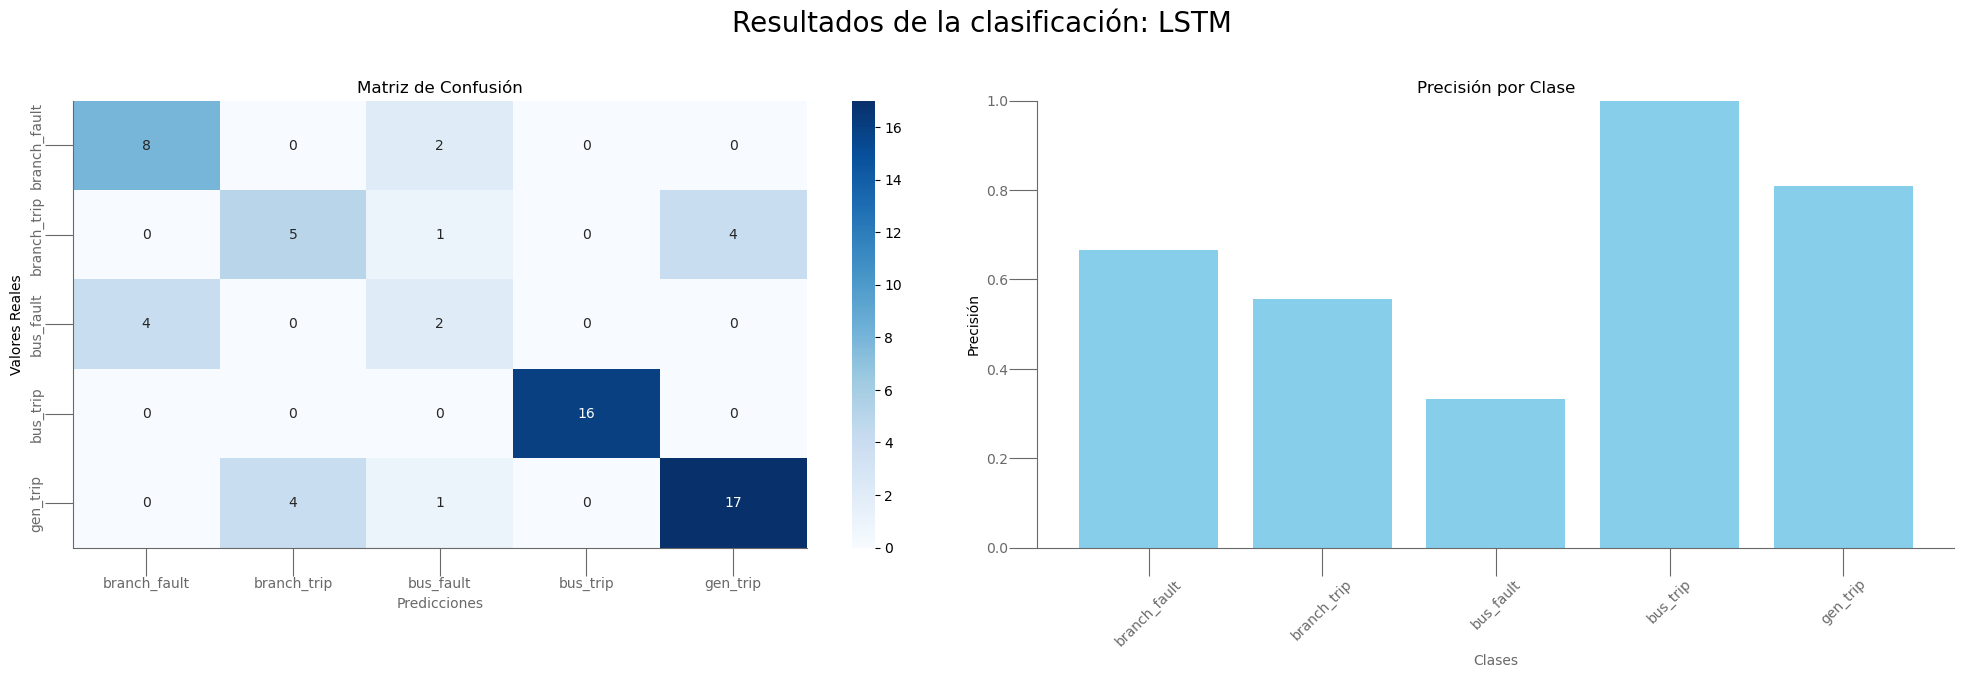

In [17]:
test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = mejor_trainer.test()
plot_clasificacion(real, preds, target_names, "LSTM")

In [18]:
name_model ="LSTM_BATCH"
results_save_path = "../experimentos_split/results"

path_save_experiment = results_save_path+f"/{problem}"+ f"/ajustes/{name_model}_results.csv"
resultados_df.to_csv(path_save_experiment, index=False)
mejor_trainer.save_model(path_save_experiment=path_save_experiment, params = mejores_parametros)


==================== GUARDANDO RESULTADOS ===================

       Modelo                             Params  \
0  LSTM_BATCH  {'Hidden Size': 150, 'Layers': 1}   

                      Fichero_resultados_experimento  Loss_tst  Loss_eval  \
0  ../experimentos_split/results/clasificacion/aj...  1.159883    1.17706   

   Loss_final  Accuracy_eval  Precision_eval  Recall_eval   F1_eval  \
0    1.053747        0.71875         0.68254     0.713932  0.674393   

   Accuracy_tst  Precision_tst  Recall_tst    F1_tst  
0          0.75       0.681212    0.673016  0.675524  

==================== RESULTADOS GUARDADOS ===================



## Bucle rápido para ajustar y guardar resultados sin batch

In [19]:


param_grid = {
    "hidden_size": [50, 100, 150],  
    "n_layers": [1, 2, 3]          
}

dataloader_params = {
    "batch_size": 32,
    "data_split_ratio": [0.7, 0.15, 0.15],
    "seed": 42,
    "keep_same": True,
    "use_batch": False
}

num_early_stop = 10
num_epochs = 100
problem = "clasificacion"

mejor_trainer, mejores_parametros, mejores_resultados, resultados_df = entrenar_y_evaluar_modelos(
    param_grid, 
    dataset_full, 
    dataloader_params, 
    num_early_stop, 
    num_epochs, 
    problem, "LSTM_NOBATCH",target_names)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 390
Validation dataset: 75
Test dataset: 84

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 1.5545 | Eval Loss: 1.4827 | Accuracy: 0.4800 | Precision: 0.3240 | Recall: 0.3000 | F1-Score: 0.2541 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 1.5078 | Eval Loss: 1.4515 | Accuracy: 0.5333 | Precision: 0.2155 | Recall: 0.3571 | F1-Score: 0.2675 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 1.4860 | Eval Loss: 1.4094 | Accuracy: 0.5600 | Precision: 0.2246 | Recall: 0.3857 | F1-Score: 0.2838 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 1.4620 | Eval Loss: 1.3962 | Accuracy: 0.5600 | Precision: 0.2221 | Recall: 0.3857 | F1-Score: 0.2818 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 1.4443 | Eval Loss: 1.3801 | Accuracy: 0.5600 | Precision: 0.2246 | Recall: 0.3857 | F1-Score: 0.2838 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 1.4343 | Eval Loss: 1.3654 | Accuracy: 0.5600 | Precision: 0.2221 | Recall: 0.3857 | 

 11%|█         | 1/9 [01:46<14:13, 106.73s/it]

              precision    recall  f1-score   support

           0       0.78      0.58      0.67        12
           1       0.61      0.73      0.67        15
           2       0.44      0.44      0.44         9
           3       1.00      1.00      1.00        19
           4       0.83      0.83      0.83        29

    accuracy                           0.77        84
   macro avg       0.73      0.72      0.72        84
weighted avg       0.78      0.77      0.77        84

preds:  torch.Size([])
test loss: 1.175034, test accuracy: 0.7738, test precision: 0.7322, test recall: 0.7177, test F1-score: 0.7211
Parámetros:  50 1
Resultados:  {'Hidden Size': 50, 'Layers': 1, 'Loss_final': 1.0999921560287476, 'Accuracy_eval': 0.6497435897435898, 'Precision_eval': 0.5212318223428785, 'Recall_eval': 0.5755475558923835, 'F1_eval': 0.5251610782713644, 'Loss_eval': 1.2059091329574585, 'Loss_tst': 1.1750344038009644, 'Accuracy_tst': 0.7738095238095238, 'Precision_tst': 0.7321839080459769, 

 22%|██▏       | 2/9 [04:03<14:30, 124.35s/it]

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        12
           1       1.00      0.33      0.50        15
           2       0.00      0.00      0.00         9
           3       1.00      0.89      0.94        19
           4       0.69      1.00      0.82        29

    accuracy                           0.75        84
   macro avg       0.67      0.65      0.61        84
weighted avg       0.74      0.75      0.70        84

preds:  torch.Size([])
test loss: 1.166823, test accuracy: 0.7500, test precision: 0.6714, test recall: 0.6456, test F1-score: 0.6123
Parámetros:  50 2
Resultados:  {'Hidden Size': 50, 'Layers': 2, 'Loss_final': 1.1535260677337646, 'Accuracy_eval': 0.6297435897435897, 'Precision_eval': 0.5108890699870343, 'Recall_eval': 0.5938025767336111, 'F1_eval': 0.5210460484142335, 'Loss_eval': 1.2049187421798706, 'Loss_tst': 1.166823387145996, 'Accuracy_tst': 0.75, 'Precision_tst': 0.6714285714285714, 'Recall_tst': 0

 33%|███▎      | 3/9 [06:40<13:55, 139.24s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       1.00      1.00      1.00        19
           4       0.62      1.00      0.76        29

    accuracy                           0.70        84
   macro avg       0.45      0.58      0.50        84
weighted avg       0.53      0.70      0.60        84

preds:  torch.Size([])
test loss: 1.207674, test accuracy: 0.7024, test precision: 0.4528, test recall: 0.5833, test F1-score: 0.5044
Parámetros:  50 3
Resultados:  {'Hidden Size': 50, 'Layers': 3, 'Loss_final': 1.2539656162261963, 'Accuracy_eval': 0.6328205128205128, 'Precision_eval': 0.42256133195559153, 'Recall_eval': 0.5409819060250094, 'F1_eval': 0.44489111378767837, 'Loss_eval': 1.2331337928771973, 'Loss_tst': 1.2076737880706787, 'Accuracy_tst': 0.7023809523809523, 'Precision_tst': 0.4528160200250313

 44%|████▍     | 4/9 [08:27<10:32, 126.41s/it]

              precision    recall  f1-score   support

           0       0.62      0.42      0.50        12
           1       0.61      0.73      0.67        15
           2       0.30      0.33      0.32         9
           3       1.00      0.95      0.97        19
           4       0.80      0.83      0.81        29

    accuracy                           0.73        84
   macro avg       0.67      0.65      0.65        84
weighted avg       0.73      0.73      0.73        84

preds:  torch.Size([])
test loss: 1.169390, test accuracy: 0.7262, test precision: 0.6672, test recall: 0.6517, test F1-score: 0.6538
Parámetros:  100 1
Resultados:  {'Hidden Size': 100, 'Layers': 1, 'Loss_final': 1.0658342838287354, 'Accuracy_eval': 0.655128205128205, 'Precision_eval': 0.5529669157677031, 'Recall_eval': 0.5975459454338765, 'F1_eval': 0.552331723612455, 'Loss_eval': 1.193995714187622, 'Loss_tst': 1.1693896055221558, 'Accuracy_tst': 0.7261904761904762, 'Precision_tst': 0.6672222222222223, '

 56%|█████▌    | 5/9 [10:48<08:47, 131.77s/it]

              precision    recall  f1-score   support

           0       0.69      0.92      0.79        12
           1       0.00      0.00      0.00        15
           2       0.33      0.11      0.17         9
           3       1.00      0.89      0.94        19
           4       0.60      1.00      0.75        29

    accuracy                           0.69        84
   macro avg       0.52      0.58      0.53        84
weighted avg       0.57      0.69      0.60        84

preds:  torch.Size([])
test loss: 1.211062, test accuracy: 0.6905, test precision: 0.5250, test recall: 0.5845, test F1-score: 0.5300
Parámetros:  100 2
Resultados:  {'Hidden Size': 100, 'Layers': 2, 'Loss_final': 1.2278368473052979, 'Accuracy_eval': 0.652051282051282, 'Precision_eval': 0.5401233291325997, 'Recall_eval': 0.590652709359606, 'F1_eval': 0.5292941117135194, 'Loss_eval': 1.2313951253890991, 'Loss_tst': 1.2110620737075806, 'Accuracy_tst': 0.6904761904761905, 'Precision_tst': 0.5249999999999999, 

 67%|██████▋   | 6/9 [13:46<07:22, 147.42s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       1.00      1.00      1.00        19
           4       0.62      1.00      0.76        29

    accuracy                           0.70        84
   macro avg       0.45      0.58      0.50        84
weighted avg       0.53      0.70      0.60        84

preds:  torch.Size([])
test loss: 1.208354, test accuracy: 0.7024, test precision: 0.4528, test recall: 0.5833, test F1-score: 0.5044
Parámetros:  100 3
Resultados:  {'Hidden Size': 100, 'Layers': 3, 'Loss_final': 1.248697280883789, 'Accuracy_eval': 0.5628205128205128, 'Precision_eval': 0.31372009451810323, 'Recall_eval': 0.4510065365668815, 'F1_eval': 0.35163267193978187, 'Loss_eval': 1.228171467781067, 'Loss_tst': 1.2083536386489868, 'Accuracy_tst': 0.7023809523809523, 'Precision_tst': 0.4528160200250313

 78%|███████▊  | 7/9 [15:34<04:29, 134.63s/it]

              precision    recall  f1-score   support

           0       0.55      0.50      0.52        12
           1       0.78      0.47      0.58        15
           2       0.14      0.11      0.12         9
           3       1.00      1.00      1.00        19
           4       0.71      0.93      0.81        29

    accuracy                           0.71        84
   macro avg       0.64      0.60      0.61        84
weighted avg       0.70      0.71      0.70        84

preds:  torch.Size([])
test loss: 1.163815, test accuracy: 0.7143, test precision: 0.6353, test recall: 0.6018, test F1-score: 0.6072
Parámetros:  150 1
Resultados:  {'Hidden Size': 150, 'Layers': 1, 'Loss_final': 1.1192991733551025, 'Accuracy_eval': 0.6715384615384613, 'Precision_eval': 0.5704392154555052, 'Recall_eval': 0.6267563471011747, 'F1_eval': 0.5793022838496985, 'Loss_eval': 1.1894994974136353, 'Loss_tst': 1.1638151407241821, 'Accuracy_tst': 0.7142857142857143, 'Precision_tst': 0.6353231563757878

 89%|████████▉ | 8/9 [17:51<02:15, 135.45s/it]

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       1.00      0.95      0.97        19
           4       0.63      1.00      0.77        29

    accuracy                           0.70        84
   macro avg       0.45      0.59      0.50        84
weighted avg       0.53      0.70      0.60        84

preds:  torch.Size([])
test loss: 1.203438, test accuracy: 0.7024, test precision: 0.4524, test recall: 0.5895, test F1-score: 0.5041
Parámetros:  150 2
Resultados:  {'Hidden Size': 150, 'Layers': 2, 'Loss_final': 1.2598536014556885, 'Accuracy_eval': 0.6438461538461537, 'Precision_eval': 0.45295567468859904, 'Recall_eval': 0.5398228495642289, 'F1_eval': 0.4665169965846505, 'Loss_eval': 1.243560791015625, 'Loss_tst': 1.2034378051757812, 'Accuracy_tst': 0.7023809523809523, 'Precision_tst': 0.4524027459954233

100%|██████████| 9/9 [20:35<00:00, 137.24s/it]

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.00      0.00      0.00        15
           2       0.33      0.11      0.17         9
           3       1.00      1.00      1.00        19
           4       0.62      1.00      0.76        29

    accuracy                           0.70        84
   macro avg       0.52      0.59      0.53        84
weighted avg       0.57      0.70      0.61        84

preds:  torch.Size([])
test loss: 1.197785, test accuracy: 0.7024, test precision: 0.5234, test recall: 0.5889, test F1-score: 0.5341
Parámetros:  150 3
Resultados:  {'Hidden Size': 150, 'Layers': 3, 'Loss_final': 1.2574917078018188, 'Accuracy_eval': 0.6366666666666666, 'Precision_eval': 0.4065828233118548, 'Recall_eval': 0.5341677718832891, 'F1_eval': 0.4443996559318001, 'Loss_eval': 1.2241040468215942, 'Loss_tst': 1.1977847814559937, 'Accuracy_tst': 0.7023809523809523, 'Precision_tst': 0.5234042553191489


==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.55      0.50      0.52        12
           1       0.78      0.47      0.58        15
           2       0.14      0.11      0.12         9
           3       1.00      1.00      1.00        19
           4       0.71      0.93      0.81        29

    accuracy                           0.71        84
   macro avg       0.64      0.60      0.61        84
weighted avg       0.70      0.71      0.70        84

preds:  torch.Size([])
test loss: 1.163815, test accuracy: 0.7143, test precision: 0.6353, test recall: 0.6018, test F1-score: 0.6072


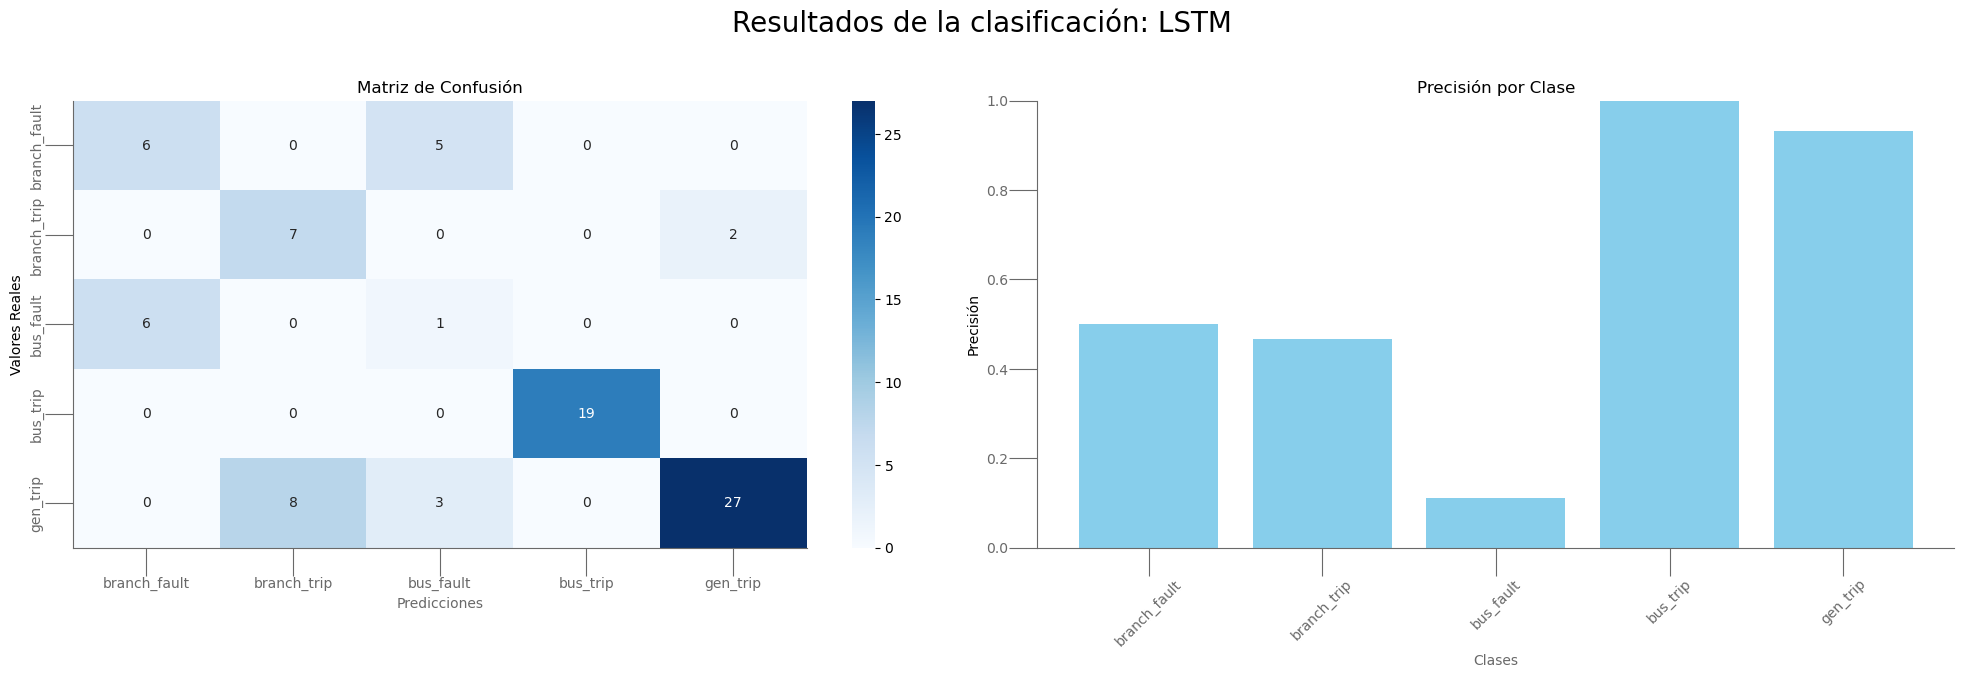

In [20]:
test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = mejor_trainer.test()
plot_clasificacion(real, preds, target_names, "LSTM")

In [21]:
name_model ="LSTM_BATCH"
results_save_path = "../experimentos_split/results"

path_save_experiment = results_save_path+f"/{problem}"+ f"/ajustes/{name_model}_results.csv"
resultados_df.to_csv(path_save_experiment, index=False)
mejor_trainer.save_model(path_save_experiment=path_save_experiment, params = mejores_parametros)


==================== GUARDANDO RESULTADOS ===================

         Modelo                             Params  \
0    LSTM_BATCH  {'Hidden Size': 150, 'Layers': 1}   
1  LSTM_NOBATCH  {'Hidden Size': 150, 'Layers': 1}   

                      Fichero_resultados_experimento  Loss_tst  Loss_eval  \
0  ../experimentos_split/results/clasificacion/aj...  1.159883   1.177060   
1  ../experimentos_split/results/clasificacion/aj...  1.163815   1.189499   

   Loss_final  Accuracy_eval  Precision_eval  Recall_eval   F1_eval  \
0    1.053747       0.718750        0.682540     0.713932  0.674393   
1    1.119299       0.706667        0.677778     0.660493  0.660158   

   Accuracy_tst  Precision_tst  Recall_tst    F1_tst  
0      0.750000       0.681212    0.673016  0.675524  
1      0.714286       0.635323    0.601762  0.607209  

==================== RESULTADOS GUARDADOS ===================

